The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [384]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# stop words
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# general
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier, StackingClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# visualisation
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read data into Dataframes


In [385]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

# Explore Data

In [386]:
print('*'*60)
print("Shape of dataset : ",train_df.shape)
print('*'*60)
print("NUMERICAL DATA ANALYSIS")
print('*'*60)
display(train_df.describe().T)
print('*'*60)
print("CATEGORICAL DATA ANALYSIS")
print('*'*60)
display(train_df.describe(exclude = ['float', 'int64']).T)
print('*'*60)
print("MISSING VALUES")
print('*'*60)
print(train_df.isnull().sum())
print('*'*60)

************************************************************
Shape of dataset :  (3004, 27)
************************************************************
NUMERICAL DATA ANALYSIS
************************************************************


,count,mean,std,min,25%,50%,75%,max
id,3004.0,1.502500e+03,8.673244e+02,1.0000,7.517500e+02,1.502500e+03,2.253250e+03,3.004000e+03
num_critic_for_reviews,3004.0,1.656092e+02,1.212545e+02,2.0000,7.600000e+01,1.370000e+02,2.230000e+02,8.130000e+02
duration,3004.0,1.100766e+02,2.191061e+01,37.0000,9.600000e+01,1.060000e+02,1.200000e+02,3.300000e+02
director_facebook_likes,3004.0,7.788901e+02,2.990742e+03,0.0000,1.000000e+01,6.250000e+01,2.340000e+02,2.300000e+04
actor_3_facebook_likes,3004.0,7.678602e+02,1.901991e+03,0.0000,1.910000e+02,4.330000e+02,6.830000e+02,2.300000e+04
actor_1_facebook_likes,3004.0,7.654936e+03,1.648876e+04,0.0000,7.285000e+02,1.000000e+03,1.200000e+04,6.400000e+05
gross,3004.0,5.187733e+07,6.840156e+07,162.0000,8.579684e+06,3.020586e+07,6.647359e+07,6.586723e+08
num_voted_users,3004.0,1.049017e+05,1.508573e+05,91.0000,1.897825e+04,5.387400e+04,1.284895e+05,1.689764e+06
cast_total_facebook_likes,3004.0,1.139164e+04,2.004472e+04,0.0000,1.873000e+03,3.889000e+03,1.592525e+04,6.567300e+05
facenumber_in_poster,3004.0,1.380826e+00,2.093417e+00,0.0000,0.000000e+00,1.000000e+00,2.000000e+00,4.300000e+01


************************************************************
CATEGORICAL DATA ANALYSIS
************************************************************


,count,unique,top,freq
director_name,3004,1460,Steven Spielberg,21
actor_2_name,3004,1903,Morgan Freeman,15
genres,3004,675,Comedy|Drama|Romance,122
actor_1_name,3004,1265,Johnny Depp,30
movie_title,3004,2942,King Kong,3
actor_3_name,3004,2198,Robert Duvall,7
plot_keywords,3004,2943,eighteen wheeler|illegal street racing|truck|t...,3
language,3003,32,English,2872
country,3004,42,USA,2382
content_rating,3004,12,R,1362


************************************************************
MISSING VALUES
************************************************************
id                           0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     1
country                      0
content_rating               0
title_year                   0
actor_2_facebook_likes       0
movie_facebook_likes         0
title_embedding              0
average_degree_centrality    0
imdb_score_binned            0
dtype: int64
*************

In [387]:
# Define features 
numeric_features = list(train_df.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = train_df.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)

['id', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality', 'imdb_score_binned']
['genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Visualise Data

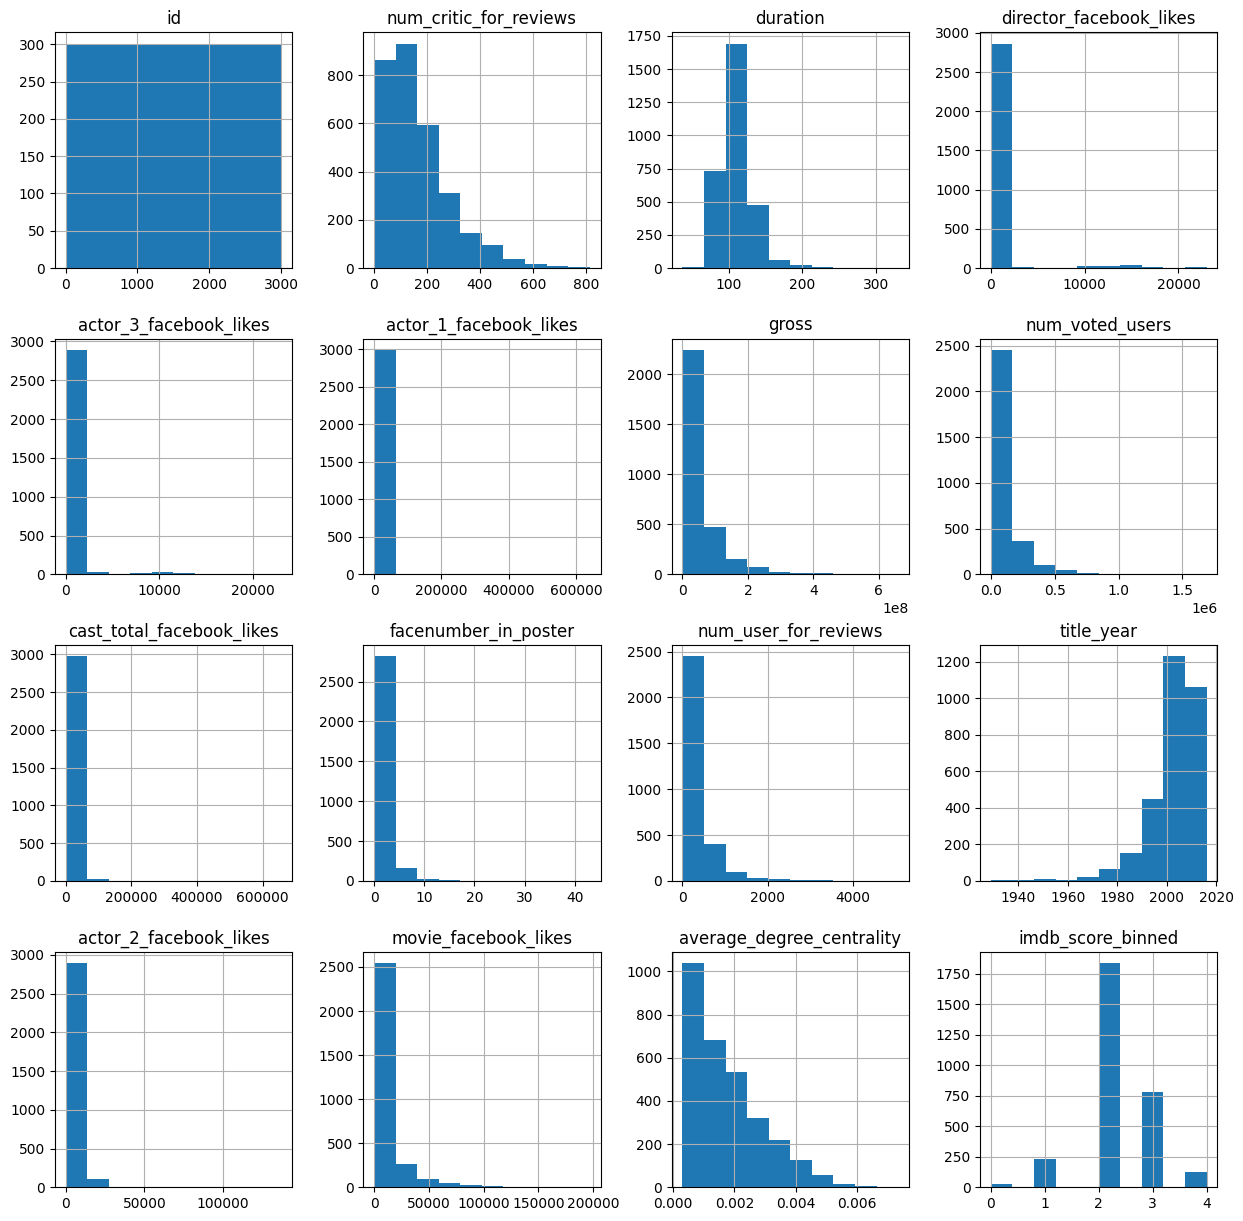

In [388]:
histograms = train_df.hist(figsize = [15, 15])
plt.savefig('./visualisations/histograms.png')

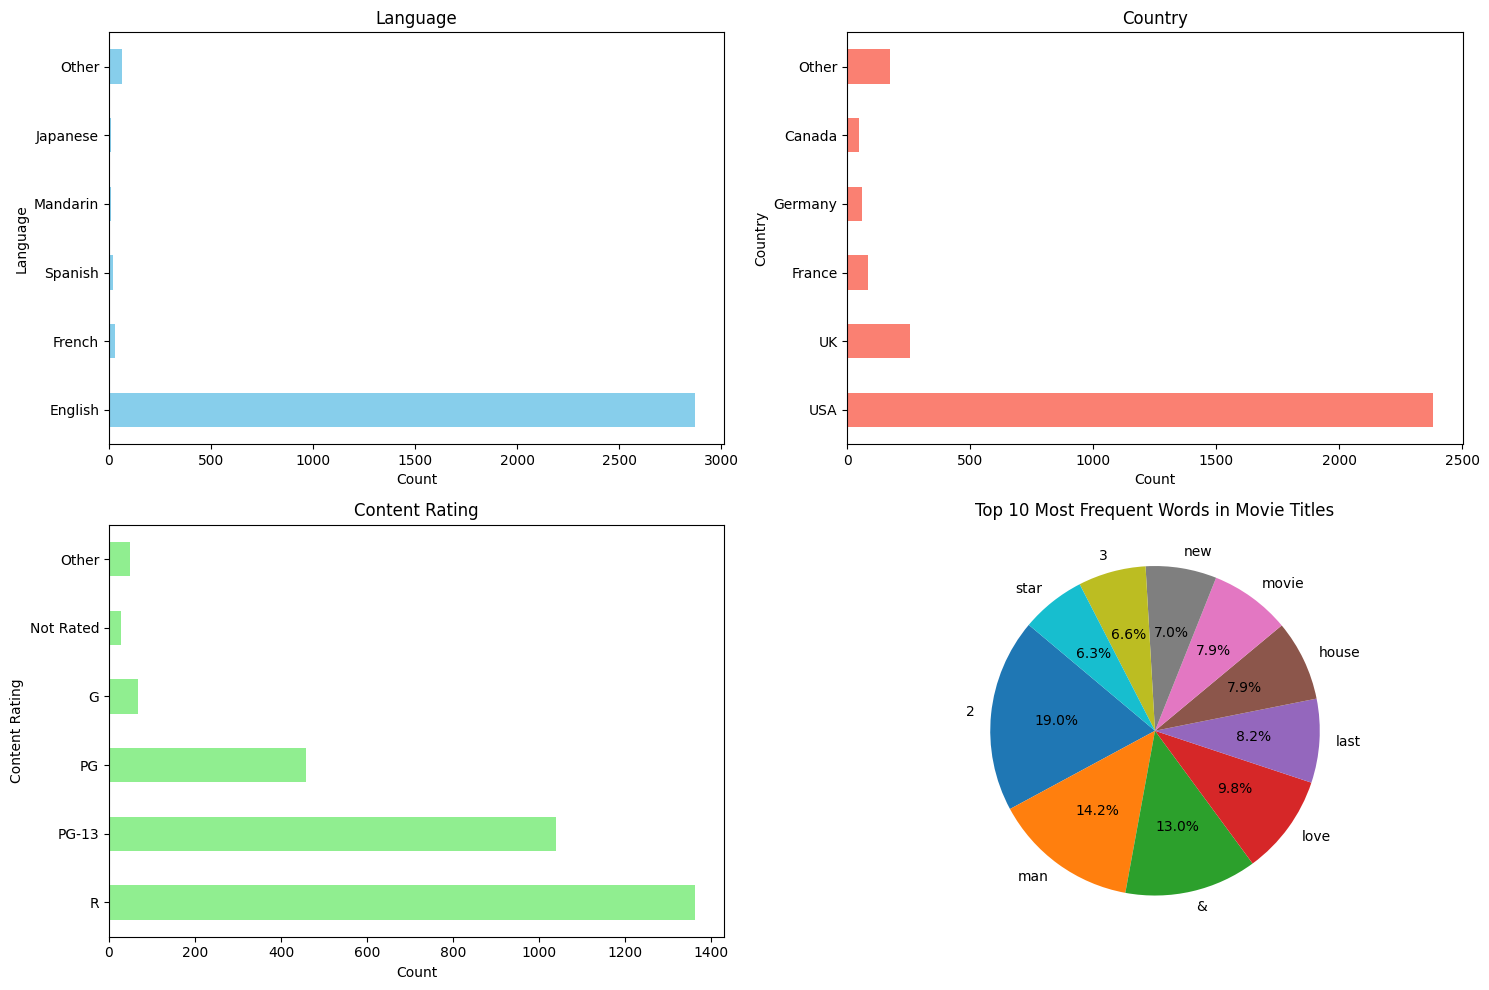

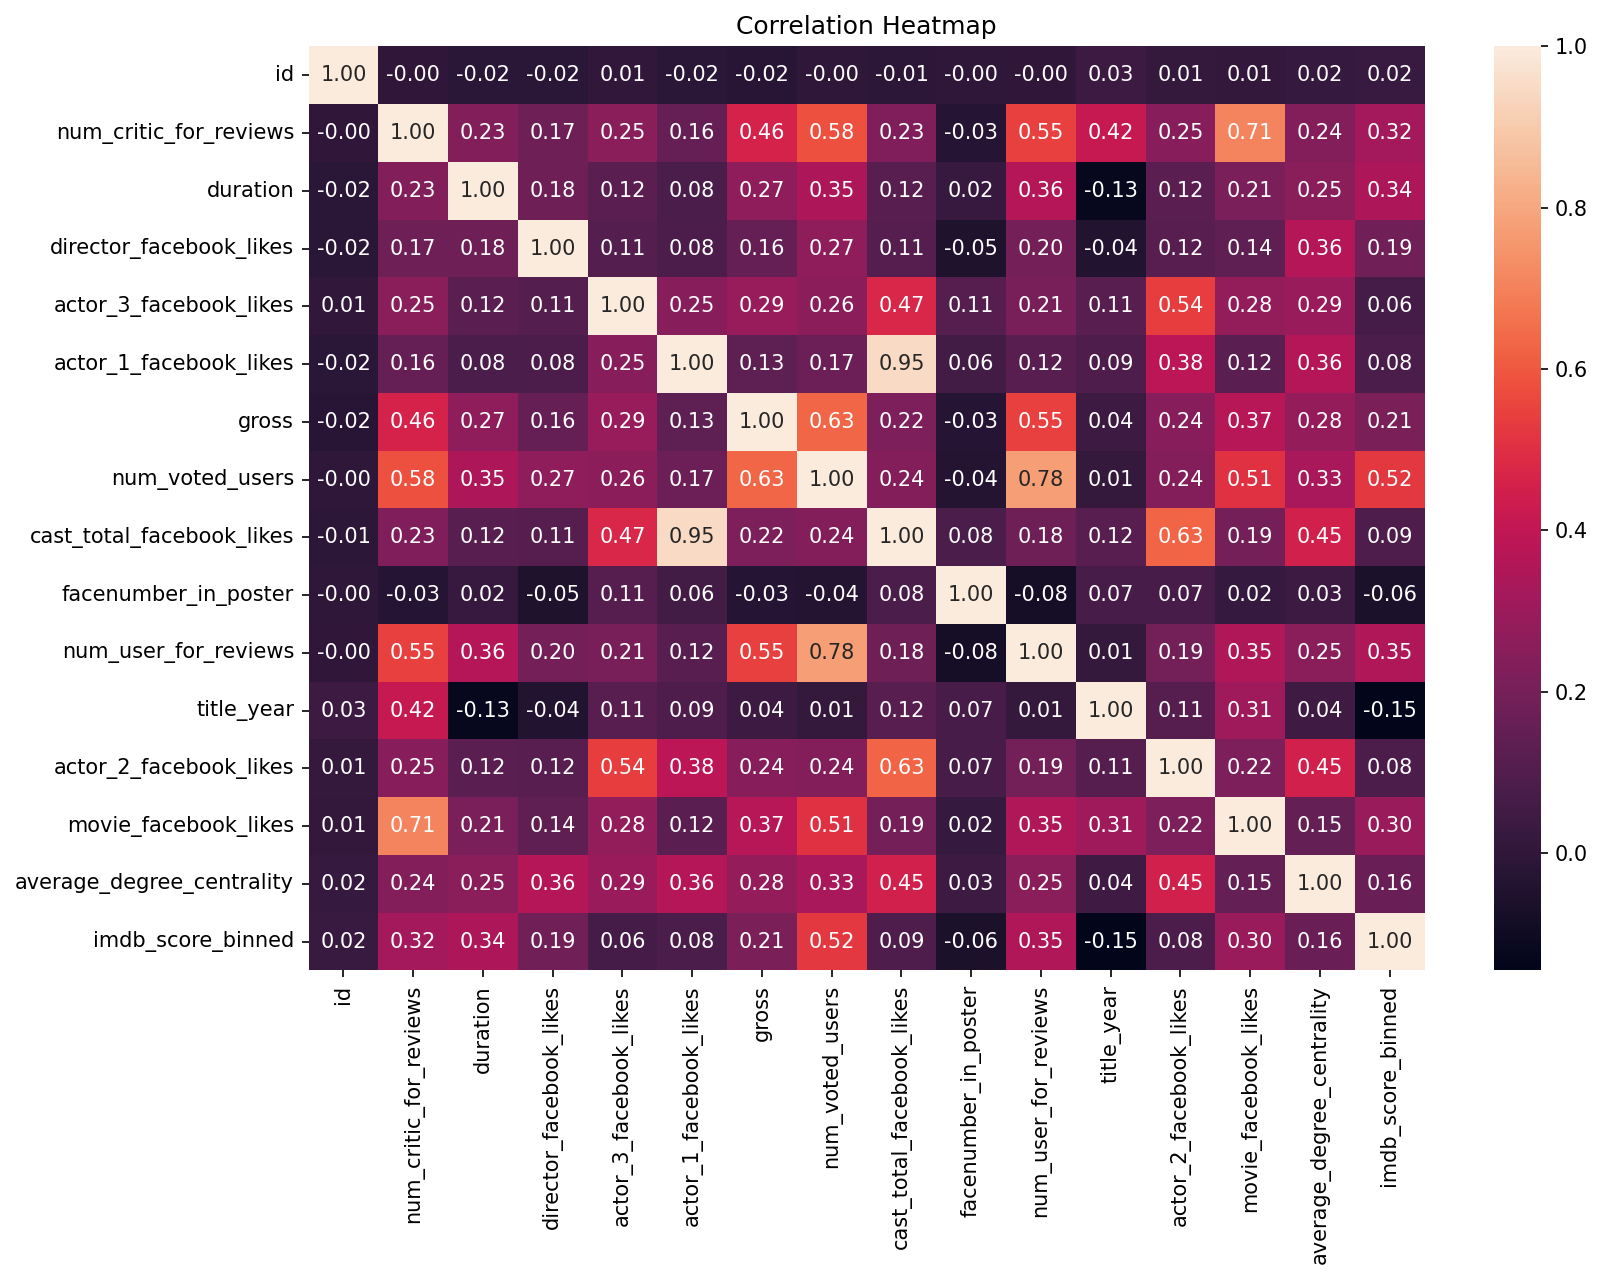

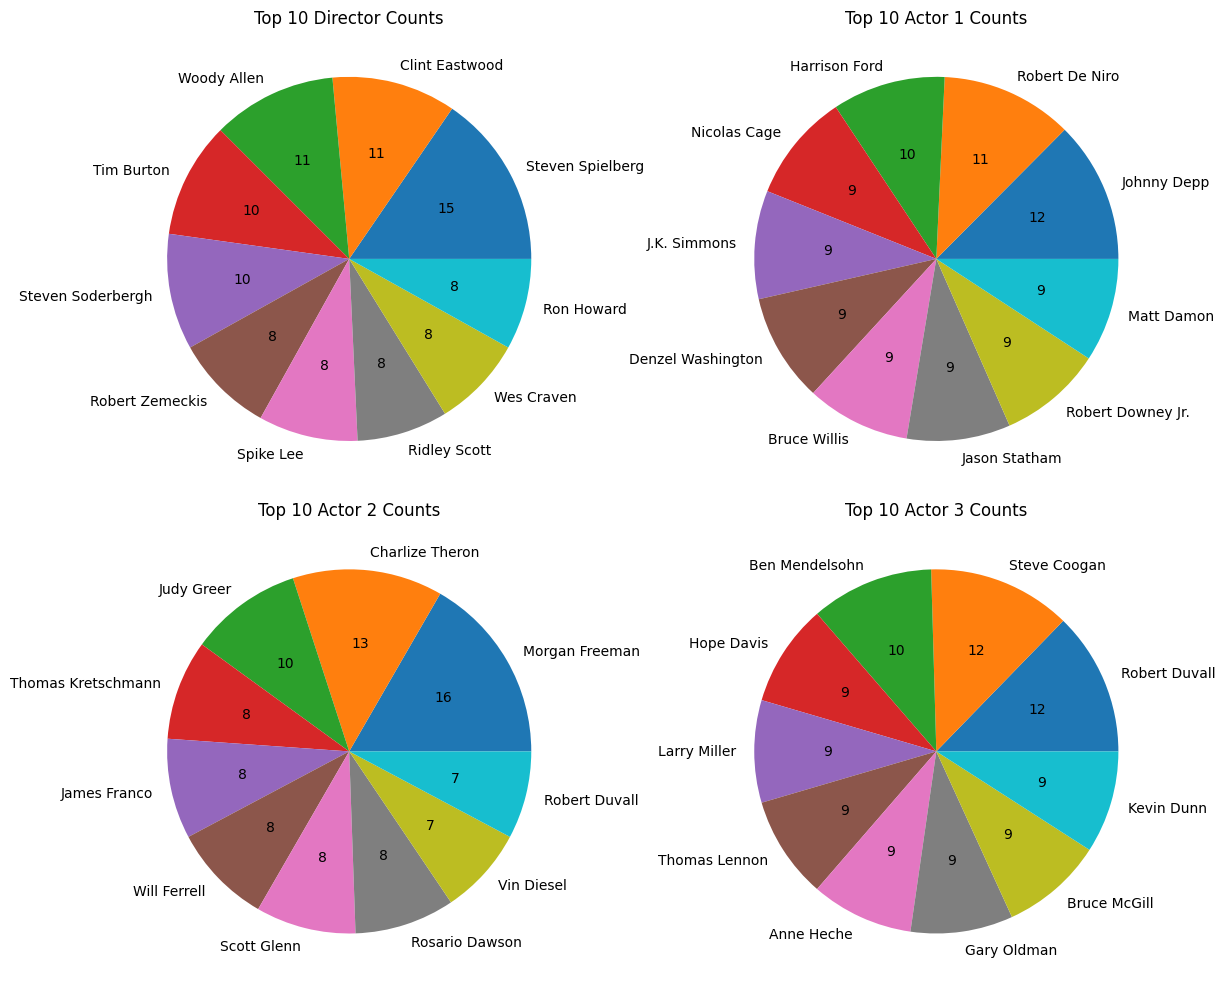

In [389]:
#Plotting the categorical variables on the target

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot horizontal bar plot for language
language_counts = train_df['language'].value_counts()
top_languages = language_counts[:5]  # Display only the top 5 languages
other_languages_count = language_counts[5:].sum()
top_languages['Other'] = other_languages_count
top_languages.plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Language')
axes[0, 0].set_ylabel('Language')
axes[0, 0].set_xlabel('Count')

# Plot horizontal bar plot for country
country_counts = train_df['country'].value_counts()
top_countries = country_counts[:5]  # Display only the top 5 countries
other_countries_count = country_counts[5:].sum()
top_countries['Other'] = other_countries_count
top_countries.plot(kind='barh', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Country')
axes[0, 1].set_ylabel('Country')
axes[0, 1].set_xlabel('Count')

# Plot horizontal bar plot for content rating
content_rating_counts = train_df['content_rating'].value_counts()
top_content_ratings = content_rating_counts[:5]  # Display only the top 5 content ratings
other_content_rating_count = content_rating_counts[5:].sum()
top_content_ratings['Other'] = other_content_rating_count
top_content_ratings.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Content Rating')
axes[1, 0].set_ylabel('Content Rating')
axes[1, 0].set_xlabel('Count')

# Plot for title words
# Flatten the list of lists into a single list of words
words = train_df['movie_title'].apply(lambda x: x.split())
all_words = [word.lower() for title_words in words for word in title_words]
filtered_unique_words = [word for word in all_words if word.lower() not in stop_words]

# Count the occurrences of each word
word_counts = Counter(filtered_unique_words)
top_words = word_counts.most_common(10)

# Plot the pie chart
ax = axes[1, 1]
ax.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%', startangle=140)
ax.set_title('Top 10 Most Frequent Words in Movie Titles')

plt.tight_layout()
plt.savefig('./visualisations/categorical-counts.png')
plt.show()

# Correlation HeatMap
plt.figure(figsize=(12,8), dpi=150)
plt.title("Correlation Heatmap")
sns.heatmap(train_df[numeric_features].corr(), annot=True, fmt='.2f')

plt.savefig('./visualisations/correlation_heatmap.png')
plt.show()

director_counts = train_df['director_name'].value_counts().head(10)
actor1_counts = train_df['actor_1_name'].value_counts().head(10)
actor2_counts = train_df['actor_2_name'].value_counts().head(10)
actor3_counts = train_df['actor_3_name'].value_counts().head(10)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].pie(director_counts, labels=director_counts.index, autopct='%d')
axs[0, 0].set_title('Top 10 Director Counts')

axs[0, 1].pie(actor1_counts, labels=actor1_counts.index, autopct='%d')
axs[0, 1].set_title('Top 10 Actor 1 Counts')

axs[1, 0].pie(actor2_counts, labels=actor2_counts.index, autopct='%d')
axs[1, 0].set_title('Top 10 Actor 2 Counts')

axs[1, 1].pie(actor3_counts, labels=actor3_counts.index, autopct='%d')
axs[1, 1].set_title('Top 10 Actor 3 Counts')

plt.tight_layout()
plt.savefig('./visualisations/name_counts.png')
plt.show()




# Feature Engineering 

## Feature: ID

In [390]:
train_df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

## Feature: Plot Keywords

In [391]:
# Load the features from the .npy files
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')

# Convert features to strings and assign them to DataFrame columns
train_df['plot_keywords'] = [str(feature) for feature in train_doc2vec_features_plot_keywords]
test_df['plot_keywords'] = [str(feature) for feature in test_doc2vec_features_plot_keywords]

## Feature: Genres


In [392]:
# Convert genres to individual columns (OneHotEncoding)
genre_dummies = train_df['genres'].str.get_dummies(sep='|')
genre_dummies.drop(columns='Film-Noir', inplace=True)         # Only occurs once
train_df = pd.concat([train_df, genre_dummies], axis=1)
train_df.drop(columns='genres', inplace=True)

genre_dummies_test = test_df['genres'].str.get_dummies(sep='|')
test_df = pd.concat([test_df, genre_dummies_test], axis=1)
test_df.drop(columns='genres', inplace=True)

print(train_df.shape)

(3004, 46)


## Feature: Facebook Likes

In [393]:
train_df['other_actor_facebook_likes'] = train_df["actor_2_facebook_likes"] + train_df['actor_3_facebook_likes']
test_df['other_actor_facebook_likes'] = test_df["actor_2_facebook_likes"] + test_df['actor_3_facebook_likes']

train_df.drop(columns=['cast_total_facebook_likes', 'actor_2_facebook_likes', "actor_3_facebook_likes"], inplace=True)
test_df.drop(columns=['cast_total_facebook_likes', 'actor_2_facebook_likes', "actor_3_facebook_likes"], inplace=True)

print(train_df.shape)

(3004, 44)


## Feature: Content Rating


In [394]:
print(train_df['content_rating'].unique())
print(test_df['content_rating'].unique())

rating_map = {
    'G' : 'PG',
    'PG': 'PG',
    'GP': 'PG',
    'PG-13': 'M',
    'M': 'M',
    'Not Rated': 'Unrated',
    'Unrated': 'Unrated',
    'R': 'X',
    'X': 'X',
    'NC-17': 'X',
    'Approved': 'Other',
    'Passed': 'Other'
}

train_df['content_rating'] = train_df['content_rating'].map(rating_map)
test_df['content_rating'] = test_df['content_rating'].map(rating_map)

print(train_df['content_rating'].unique())
print(test_df['content_rating'].unique())

print(train_df.shape)

['G' 'R' 'PG-13' 'Approved' 'PG' 'Not Rated' 'NC-17' 'Unrated' 'X' 'M'
 'GP' 'Passed']
['PG' 'R' 'PG-13' 'Not Rated' 'G' 'NC-17' 'X' 'Approved' 'Passed'
 'Unrated']
['PG' 'X' 'M' 'Other' 'Unrated']
['PG' 'X' 'M' 'Unrated' 'Other']
(3004, 44)


## Feature: Country

In [395]:
##get top 2 values of index
value_counts=train_df["country"].value_counts()
vals = value_counts[:2].index
print (vals)
train_df['country'] = train_df.country.where(train_df.country.isin(vals), 'other')

train_df["country"].value_counts()

Index(['USA', 'UK'], dtype='object', name='country')


country
USA      2382
other     367
UK        255
Name: count, dtype: int64

## Feature: Director

In [396]:
# Calculate the count of movies for each director
director_counts = train_df['director_name'].value_counts()
rare_directors = director_counts[director_counts == 1].index

train_df.loc[train_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'
test_df.loc[test_df['director_name'].isin(rare_directors), 'director_name'] = 'Other'

print(train_df.shape)

(3004, 44)


## Feature: Movie Title

In [397]:
def preprocess_title(title):
    # Convert to lowercase
    title = title.lower()
    # Remove punctuation
    title = title.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the title
    words = title.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    preprocessed_title = ' '.join(words)
    return preprocessed_title

# preprocess movie titles
train_df['movie_title'] = train_df['movie_title'].apply(preprocess_title)
test_df['movie_title'] = test_df['movie_title'].apply(preprocess_title)

print(train_df.shape)


(3004, 44)


## Feature: Title Year

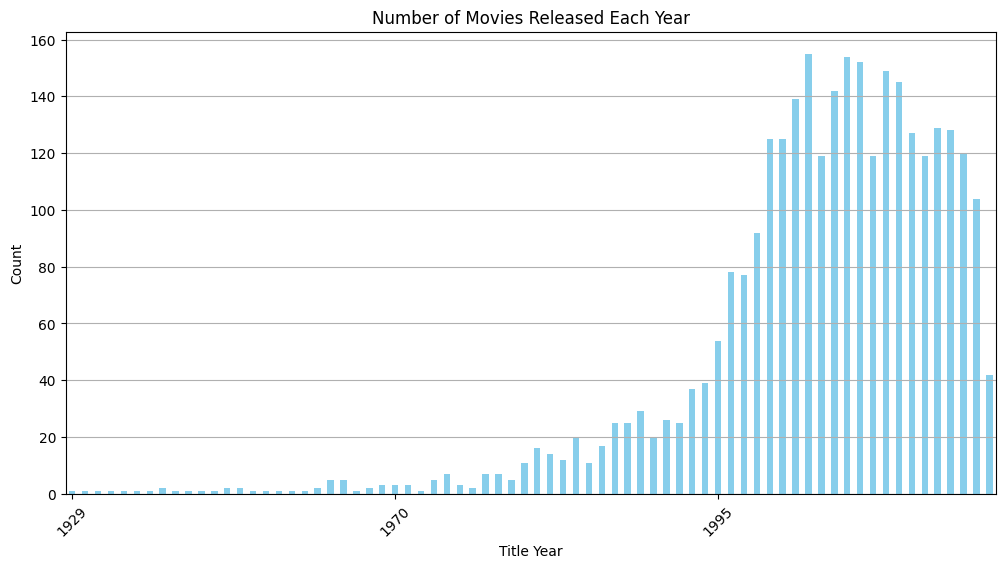

(2921, 44)


In [398]:
title_year_counts = train_df['title_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
title_year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies Released Each Year')
plt.xlabel('Title Year')
plt.ylabel('Count')
plt.xticks(range(0, len(title_year_counts.index), 25), title_year_counts.index[::25], rotation=45) 
plt.grid(axis='y') 
plt.show()

train_df = train_df[train_df['title_year'] >= 1980]

print(train_df.shape)

## Feature: Language

In [399]:
train_df = train_df.drop('language', axis=1)
test_df = test_df.drop('language', axis = 1)

print(train_df.shape)

(2921, 43)


## Dataset after feature engineering

In [400]:
print(train_df.shape, test_df.shape)
display(train_df.sample(3))

display(list(zip(train_df.columns, train_df.iloc[85])))

(2921, 43) (752, 42)


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,other_actor_facebook_likes
2859,Chuck Russell,57,114,55,Amy Yasbeck,789,119938730,Peter Greene,mask,265818,...,0,0,0,0,0,0,0,0,0,784
398,McG,96,131,368,Kimberly Williams-Paisley,11000,43532294,Matthew McConaughey,marshall,46951,...,0,0,0,0,0,1,0,0,0,912
2648,Brian Levant,67,99,32,Nichelle Nichols,773,81150692,James Coburn,snow dogs,20219,...,0,0,0,0,0,1,0,0,0,1185


[('director_name', 'Oliver Stone'),
 ('num_critic_for_reviews', 82),
 ('duration', 140),
 ('director_facebook_likes', 0),
 ('actor_2_name', 'Kevin Dillon'),
 ('actor_1_facebook_likes', 720),
 ('gross', 35183792),
 ('actor_1_name', 'Michael Wincott'),
 ('movie_title', 'doors'),
 ('num_voted_users', 68159),
 ('actor_3_name', 'Kathleen Quinlan'),
 ('facenumber_in_poster', 1),
 ('plot_keywords',
  '[-1.23007875e-03 -4.34788316e-03 -3.18447803e-03 -4.01786016e-03\n  1.73377513e-03 -7.91959581e-04 -2.98166095e-04  5.26410574e-03\n -4.53791255e-03 -2.05225660e-04 -4.87593905e-04  3.16566112e-03\n  1.01214857e-03  2.95733428e-03 -2.06076703e-03  1.75787613e-03\n -4.32217354e-03  2.49519083e-03  1.96122588e-03 -3.01964418e-03\n  1.90075487e-03  2.32633925e-03 -2.70923669e-03 -2.29909108e-03\n  3.38974106e-03  1.79756235e-03  3.82920774e-03 -2.61203083e-03\n  1.08375109e-03 -1.88913662e-03 -2.42720358e-03 -2.05748086e-03\n -1.71864592e-03  6.53369643e-04  1.31548417e-03 -2.66307802e-03\n -4.2648

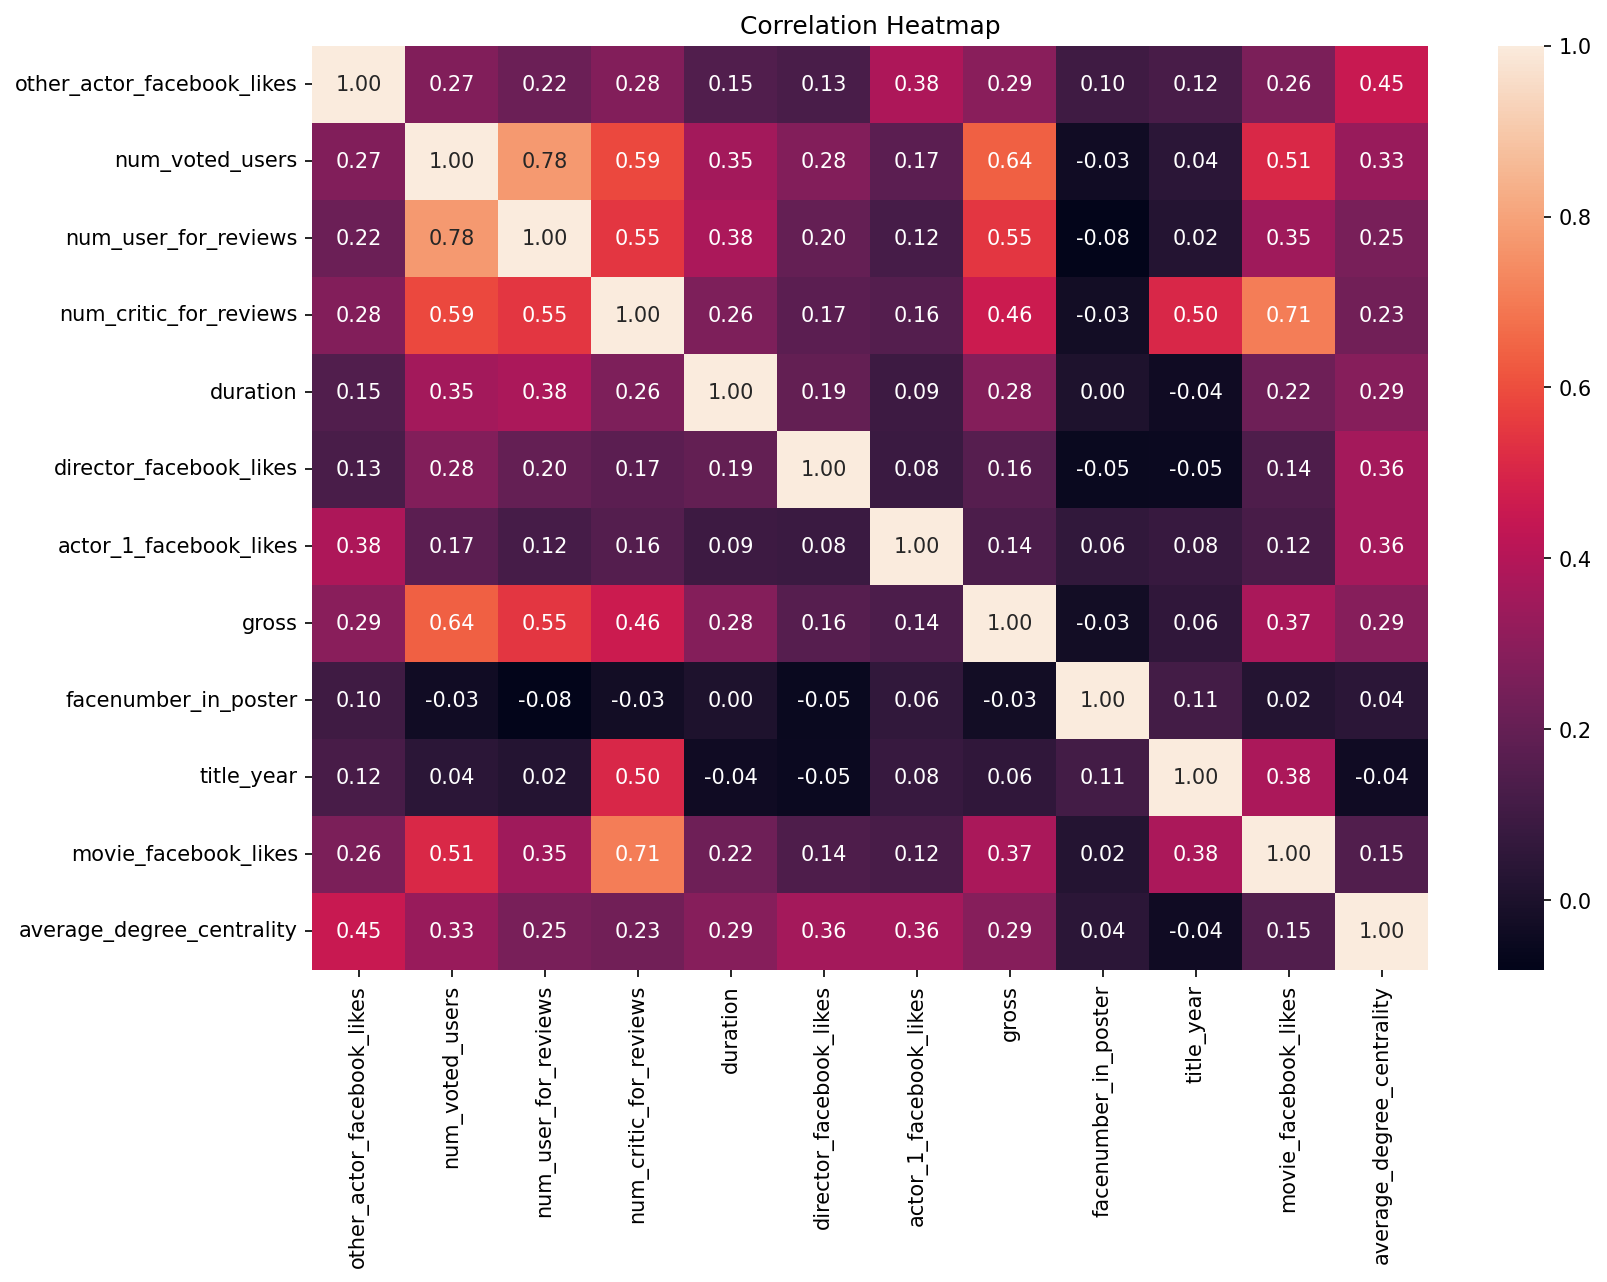

In [401]:
# Correlation HeatMap
new_features = ['other_actor_facebook_likes', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'facenumber_in_poster', 'title_year', 'movie_facebook_likes', 'average_degree_centrality']

plt.figure(figsize=(12,8), dpi=150)
plt.title("Correlation Heatmap")
sns.heatmap(train_df[new_features].corr(), annot=True, fmt='.2f')

plt.savefig('./visualisations/correlation_heatmap_post_feateng.png')
plt.show()

## Define X and y

In [402]:
X = train_df.drop(columns=["imdb_score_binned"])         
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df

print(X.shape, X_test.shape)

(2921, 42) (752, 42)


## Distribution of Movie Ratings


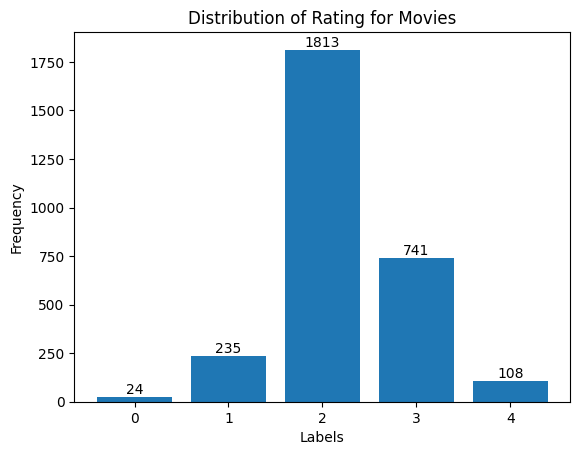

In [403]:
# Plot bar plot of y
def plot_distribution(name, labels):
    counts = np.bincount(labels)
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Distribution of Rating for Movies')

    # Annotate each bar with its count
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.savefig(f'./visualisations/{name}.png')
    plt.show()

plot_distribution("distribution_ratings", y)

In [404]:
# Update features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = X.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)


['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'movie_facebook_likes', 'average_degree_centrality', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'other_actor_facebook_likes']
['movie_title', 'plot_keywords', 'country', 'content_rating', 'title_embedding']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Data Preprocessor

In [419]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# Preprocessor for categorical strings (embedded vectors)
class StringToFloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # return csr_matrix(X.apply(lambda x: [float(value) for value in x.strip('[]').split()]).values.tolist())

        # Parse each string entry into a list of floats
        embeddings = [np.fromstring(embedding.strip('[]'), dtype=float, sep=' ') for embedding in X]
        # Calculate the average embedding for each row
        average_embeddings = [np.mean(embedding) for embedding in embeddings]
        # Return the average embeddings as a single float value for each row
        return np.array(average_embeddings).reshape(-1, 1)

embedding_transformer = Pipeline(steps=[
    ('string_to_float', StringToFloatTransformer()),  
])

# Transformers for name features
name_transformers = []
for feature in name_features:
    if feature in X.columns:
        name_transformer = Pipeline(steps=[
            ('vectorizer', TfidfVectorizer())
        ])
        name_transformers.append((feature, name_transformer, feature))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('plot', embedding_transformer, 'plot_keywords'),  
        ('title_embeddings', embedding_transformer, 'title_embedding'),  
        ('title', TfidfVectorizer(), 'movie_title'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['country', 'content_rating']),
        # *name_transformers
    ])

print(X.shape, X_test.shape)

X_processed = preprocessor.fit_transform(X)
print("Shape of processed data:", X_processed.shape)
print(list(X_processed[0].toarray()[0]))
# print(list(X_processed[0]))

(2921, 42) (752, 42)
Shape of processed data: (2921, 3204)
[0.15853780289181635, -1.7589039698336357, -0.24997593864768444, -0.3469385438160985, 5.43723166020472, 3.6345383349343687, -0.6603001089787678, 0.7746771919259842, -1.2674420508970379, 0.3942966216521866, -0.15304051376310202, -0.5867065487287617, 1.9982898671520088, 4.391437375418466, -0.2615300206842283, -0.8104535399653874, -0.4854045707373636, -0.11326695725630949, 0.9969235955127667, 2.7415387988176896, -0.3977534055288948, -0.20426968831297693, -0.3458121575282825, -0.20877498737991604, 6.790648218381398, -0.3395750100878095, -0.5476819297887948, -0.38495691174386143, -0.2006044995561297, -0.6480965735847324, -0.20335860863918417, -0.11012498412037171, -0.18016172554731424, -8.648130414999993e-05, -0.00042229686812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Min, Max, Average, Variance

In [407]:
print("Minimum of Ratings:", round(min(y),2))
print("Maximum of Ratings:", round(max(y),2))
print("Average of Ratings:", round(np.mean(y),2))
print("Variance of Ratings:",round(np.var(y),2))

Minimum of Ratings: 0
Maximum of Ratings: 4
Average of Ratings: 2.23
Variance of Ratings: 0.46


# Model Selection - Base Classifiers 


## Train-Test Split

In [408]:
print(X.shape, y.shape)

# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2921, 42) (2921,)
(2336, 42) (2336,)
(585, 42) (585,)


In [409]:
from sklearn.metrics import precision_score, recall_score

# Define classifiers
knn = KNeighborsClassifier()
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100)
svm = SVC()

# Fit preprocessing on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Fit SMOTE on training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Define classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC()
}

accuracy_resampled = {}
accuracy_original = {}
precision_resampled = {}
precision_original = {}
recall_resampled = {}
recall_original = {}

# Fit and evaluate models
for name, clf in classifiers.items():
    # Fit SMOTE on training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

    # Fit model on resampled data
    clf.fit(X_resampled, y_resampled)
    y_pred_resampled = clf.predict(X_val_processed)
    accuracy_resampled[name] = accuracy_score(y_val, y_pred_resampled)
    precision_resampled[name] = precision_score(y_val, y_pred_resampled, average='weighted', zero_division=0)
    recall_resampled[name] = recall_score(y_val, y_pred_resampled, average='weighted', zero_division=0)

    clf.fit(X_train_processed, y_train)
    y_pred_original = clf.predict(X_val_processed)
    accuracy_original[name] = accuracy_score(y_val, y_pred_original)
    precision_original[name] = precision_score(y_val, y_pred_original, average='weighted', zero_division=0)
    recall_original[name] = recall_score(y_val, y_pred_original, average='weighted', zero_division=0)

    print(f"Classification Report for {name} on Resampled Data:")
    print(classification_report(y_val, y_pred_resampled, zero_division=0))

    print(f"Classification Report for {name} on Original Processed Data:")
    print(classification_report(y_val, y_pred_original, zero_division=0))


Classification Report for KNN on Resampled Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.14      0.57      0.23        46
           2       0.77      0.31      0.45       366
           3       0.49      0.63      0.56       155
           4       0.28      0.60      0.38        15

    accuracy                           0.42       585
   macro avg       0.34      0.42      0.32       585
weighted avg       0.63      0.42      0.45       585

Classification Report for KNN on Original Processed Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.15      0.09      0.11        46
           2       0.69      0.87      0.77       366
           3       0.62      0.37      0.47       155
           4       1.00      0.33      0.50        15

    accuracy                           0.66       585
   macro avg       0.49 

## Plot performance of base classifiers

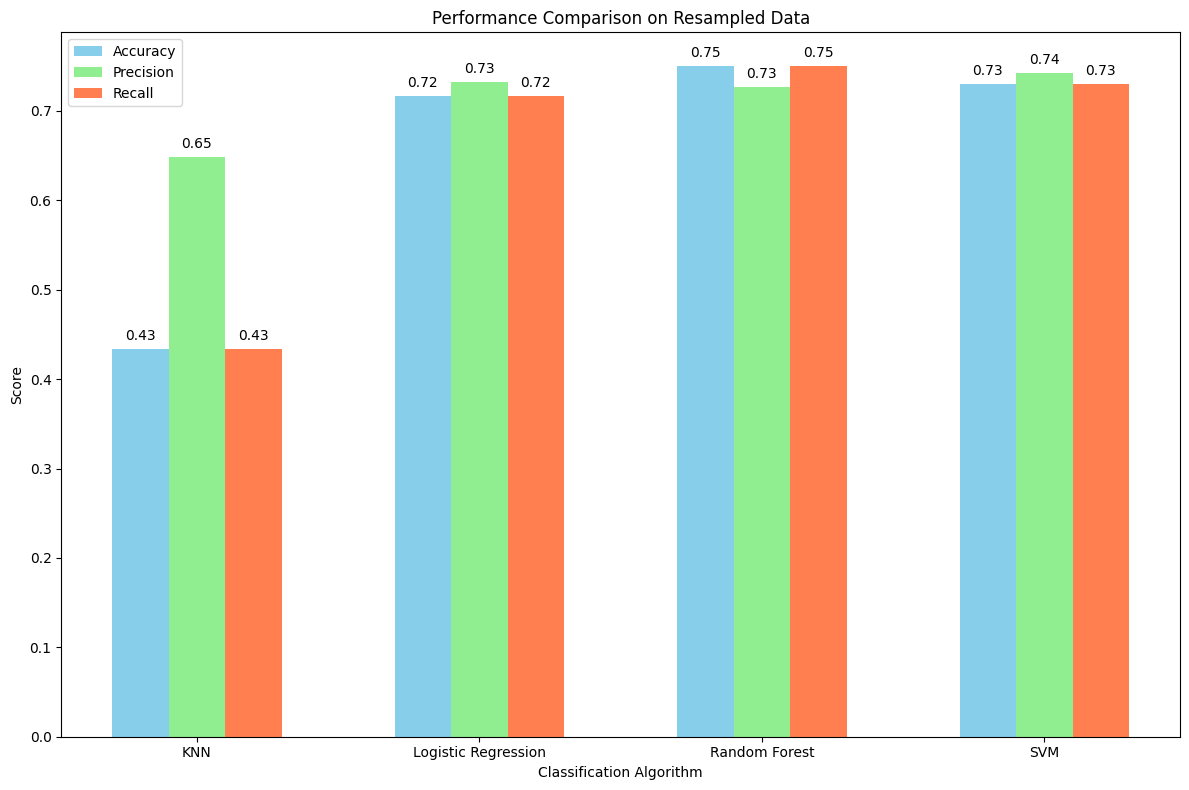

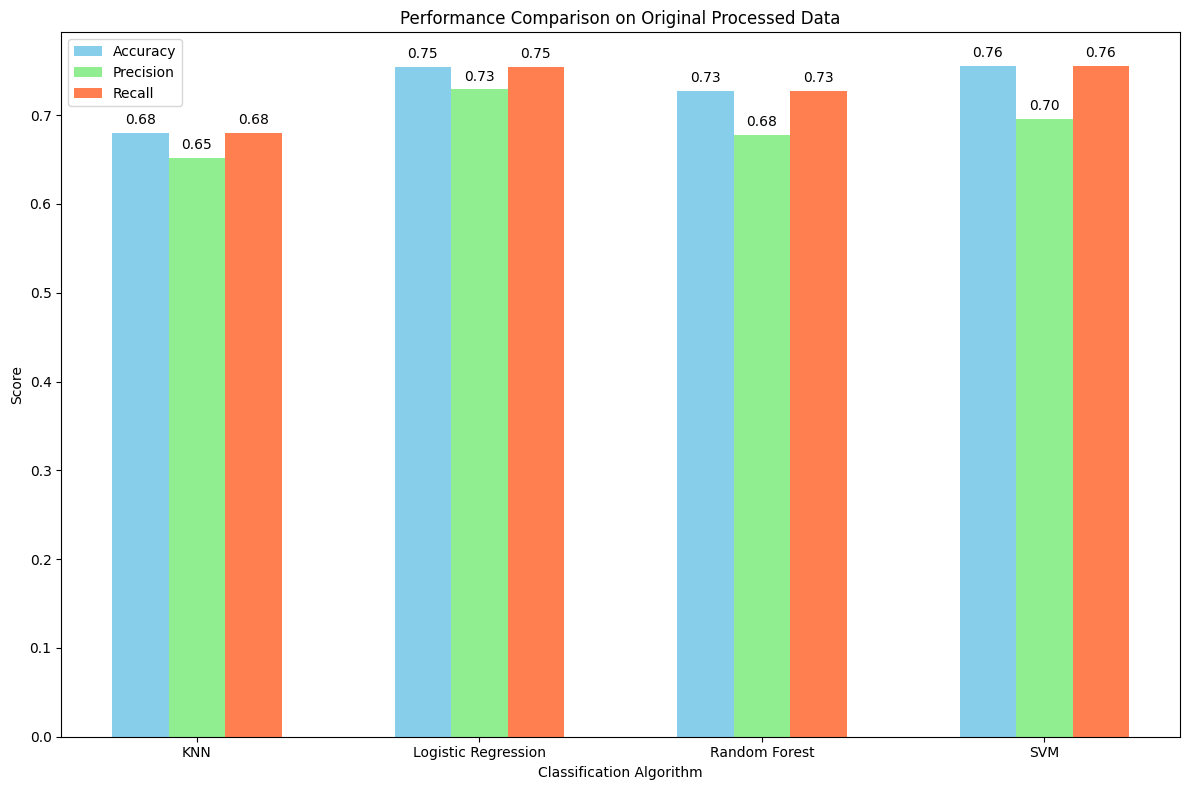

In [292]:
# Define classifiers' names
classifiers_names = classifiers

# Define the width of the bars
bar_width = 0.2

# Set the position of the bars on the x-axis
r1 = np.arange(len(classifiers_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create subplots for resampled data
plt.figure(figsize=(12, 8))
plt.bar(r1, list(accuracy_resampled.values()), color='skyblue', width=bar_width, label='Accuracy')
plt.bar(r2, list(precision_resampled.values()), color='lightgreen', width=bar_width, label='Precision')
plt.bar(r3, list(recall_resampled.values()), color='coral', width=bar_width, label='Recall')
plt.xticks([r + bar_width for r in range(len(classifiers_names))], classifiers_names)
plt.xlabel('Classification Algorithm')
plt.ylabel('Score')
plt.title('Performance Comparison on Resampled Data')
plt.legend()

# Adding values on top of the bars
for i in range(len(classifiers_names)):
    plt.text(r1[i], list(accuracy_resampled.values())[i] + 0.01, f'{list(accuracy_resampled.values())[i]:.2f}', ha='center')
    plt.text(r2[i], list(precision_resampled.values())[i] + 0.01, f'{list(precision_resampled.values())[i]:.2f}', ha='center')
    plt.text(r3[i], list(recall_resampled.values())[i] + 0.01, f'{list(recall_resampled.values())[i]:.2f}', ha='center')

plt.tight_layout()

# Create subplots for original processed data
plt.figure(figsize=(12, 8))
plt.bar(r1, list(accuracy_original.values()), color='skyblue', width=bar_width, label='Accuracy')
plt.bar(r2, list(precision_original.values()), color='lightgreen', width=bar_width, label='Precision')
plt.bar(r3, list(recall_original.values()), color='coral', width=bar_width, label='Recall')
plt.xticks([r + bar_width for r in range(len(classifiers_names))], classifiers_names)
plt.xlabel('Classification Algorithm')
plt.ylabel('Score')
plt.title('Performance Comparison on Original Processed Data')
plt.legend()

# Adding values on top of the bars
for i in range(len(classifiers_names)):
    plt.text(r1[i], list(accuracy_original.values())[i] + 0.01, f'{list(accuracy_original.values())[i]:.2f}', ha='center')
    plt.text(r2[i], list(precision_original.values())[i] + 0.01, f'{list(precision_original.values())[i]:.2f}', ha='center')
    plt.text(r3[i], list(recall_original.values())[i] + 0.01, f'{list(recall_original.values())[i]:.2f}', ha='center')

plt.tight_layout()
plt.show()

## Cross Validation between Log-Reg and SVM

In [ ]:
# Initialize classifiers
log_reg = LogisticRegression(max_iter=1000)
svm = SVC()

X_processed = preprocessor.fit_transform(X)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Perform cross-validation for logistic regression
log_reg_scores = cross_val_score(log_reg, X_processed, y, cv=cv, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", log_reg_scores)
print("Mean Accuracy:", log_reg_scores.mean())

# Perform cross-validation for SVM
svm_scores = cross_val_score(svm, X_processed, y, cv=cv, scoring='accuracy')
print("SVM Cross-Validation Scores:", svm_scores)
print("Mean Accuracy:", svm_scores.mean())

# Logistic Regression


## Learning Curve

In [ ]:
def plot_learning_curve(name, estimator, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10)):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # Create subplots
    
    for i, C_value in enumerate([1, 0.1]):  # Iterate over different values of C
        estimator.C = C_value  # Set the value of C
        
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X_train, y_train, cv=10, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
        
        # Calculate mean and standard deviation for training scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        
        # Calculate mean and standard deviation for test scores
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        # Plot learning curve for current value of C
        axs[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.1,
                            color="r")
        axs[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                            test_scores_mean + test_scores_std, alpha=0.1, color="g")
        axs[i].plot(train_sizes, train_scores_mean, 'o-', color="r",
                    label="Training score")
        axs[i].plot(train_sizes, test_scores_mean, 'o-', color="g",
                    label="Test score")
        axs[i].set_xlabel("Training examples")
        axs[i].set_ylabel("Accuracy")
        axs[i].legend(loc="best")
        axs[i].set_title(f"Learning Curve (C={C_value})")

    plt.tight_layout()  # Adjust layout
    plt.savefig(f'./visualisations/{name}_learning_curve.png')
    plt.show()

# Plot learning curve for logistic regression with different values of C
plot_learning_curve("logistic_reg", LogisticRegression(max_iter=1000), X_processed, y)


## Hyperparameter Tuning (Logistic Regression)

In [ ]:
# Define feature selection and logistic regression classifier
classifier = LogisticRegression(max_iter=1000, penalty='l2')  
feat_selection = SelectKBest(score_func=f_classif)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selection', feat_selection),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'feature_selection__k': [100, 500, 1000, 3000, "all"]
}

# Perform grid search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
logistic_grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
logistic_grid_search.fit(X, y)


In [ ]:
best_params = logistic_grid_search.best_params_
best_score = logistic_grid_search.best_score_
print(best_params)
print("Accuracy:", best_score)

# Get the best model from the grid search
reg_best_model = logistic_grid_search.best_estimator_

## Predict with Logistic Regression

In [ ]:
# Make predictions on X_test with Logistic Regression
predictions = reg_best_model.predict(X_test)
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})
prediction_df.to_csv('./predictions/logit_predictions.csv', index=False)

## Permutation Feature Importance (Logistic Regression) 

In [ ]:
# Perform permutation feature importance
perm_importance = permutation_importance(reg_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importance scores
perm_sorted_idx = perm_importance.importances_mean.argsort()

# Plot permutation feature importance
plt.figure(figsize=(12, 10))
plt.barh(range(X_val.shape[1]), perm_importance.importances_mean[perm_sorted_idx], align='center')
plt.yticks(range(X_val.shape[1]), X_val.columns[perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.savefig('./visualisations/logit_perm_importance.png')
plt.show()

## Top 15 features

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

top_15_features = list(X_val.columns[perm_sorted_idx][-15:])
print(top_15_features)

X_train_top_15 = X_train[top_15_features]
X_val_top_15 = X_val[top_15_features]

numeric_features_15 = list(X_train_top_15.select_dtypes(include=['int64', 'float64', 'float32']).columns)
name_features_15 = ['actor_2_name', 'actor_1_name', 'actor_3_name']

# Transformers for name features
name_transformers = []
for feature in name_features_15:
    if feature in X_train_top_15.columns:
        name_transformer = Pipeline(steps=[
            ('vectorizer', CountVectorizer())
        ])
        name_transformers.append((feature, name_transformer, feature))

top_15_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_15),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['content_rating']),
        *name_transformers
    ])

# Fit preprocessing on training data
X_15_train_processed = top_15_preprocessor.fit_transform(X_train_top_15)
X_15_val_processed = top_15_preprocessor.transform(X_val_top_15)

# Fit models on resampled data
knn.fit(X_15_train_processed, y_train)
log_reg.fit(X_15_train_processed, y_train)
rf.fit(X_15_train_processed, y_train)
svm.fit(X_15_train_processed, y_train)

# Predict on validation data using models trained on original processed data
knn_pred = knn.predict(X_15_val_processed)
log_reg_pred = log_reg.predict(X_15_val_processed)
rf_pred = rf.predict(X_15_val_processed)
svm_pred = svm.predict(X_15_val_processed)

# Accuracy on original processed data
knn_acc = accuracy_score(knn_pred, y_val)
reg_acc = accuracy_score(log_reg_pred, y_val)
rf_acc = accuracy_score(rf_pred, y_val)
svm_acc = accuracy_score(svm_pred, y_val)

# Define the models and their accuracies
models = ['KNN', 'Logistic Regression', 'Random Forest', 'Support Vector Machine']
accuracies = [knn_acc, reg_acc, rf_acc, svm_acc]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral', 'orange'])

# Annotate each bar with its accuracy value
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{acc:.2f}', ha='center', color='black')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models on Top 15 Selected Features')
plt.ylim(0, 1)  
plt.show()

## SVM


In [420]:
# Define feature selection, imputation, and SVM classifier
classifier = SVC(gamma='scale')

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [1, 2, 4], 
    # 'feature_selection__k': [100, 500, 1000, 3000, "all"]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)   # Verbose shows comments during search
svm_grid_search.fit(X, y)


Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.7s
[CV] END ....................................classifier__C=1; total time=   0.7s
[CV] END ....................................classifier__C=1; total time=   0.7s
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.6s
[CV] END ....................................classifier__C=1; total time=   0.7s
[CV] END ....................................classifier__C=2; total time=   0.6s
[CV] END ....................................cla

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          '...
                                                                                          StringToFloatTransformer())]),
                                                                         'plot_keywords'),
                                                                        ('title_embeddings',
                                                                         Pipeline(steps=[('string_to_float',
                                                                                          StringToFloatTransformer())]),
                                                                         'title_embedding'),
                                                                        ('title',
                                                                         TfidfVectorizer(),
                                                                         'movie_title'),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['country',
                                                                          'content_rating'])])),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [1, 2, 4]}, scoring='accuracy',
             verbose=2)

In [421]:
# Get the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = svm_grid_search.best_estimator_


Best Parameters: {'classifier__C': 4}
Best Score: 0.7423811614565039


In [422]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('./predictions/svm7_predictions.csv', index=False)

In [414]:
# Perform permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importance scores
perm_sorted_idx = perm_importance.importances_mean.argsort()

# Plot permutation feature importance
plt.figure(figsize=(12, 10))
plt.barh(range(X_val.shape[1]), perm_importance.importances_mean[perm_sorted_idx], align='center')
plt.yticks(range(X_val.shape[1]), X_val.columns[perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.savefig('./visualisations/svm_perm_importance.png')
plt.show()


KeyboardInterrupt: 

# Random Forest


In [ ]:
# Define preprocessing steps
classifier = RandomForestClassifier(n_estimators=100, 
                                    max_features='sqrt',
                                    max_depth = None,
                                    min_samples_split = 2,
                                    bootstrap=True,
                                    )

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
rf_grid_search.fit(X, y)


In [ ]:
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

rf_best_model = rf_grid_search.best_estimator_

# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)
# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})
# Write the predictions to a CSV file
prediction_df.to_csv('./predictions/rf_predictions.csv', index=False)

# Ensemble Method - Stacking

In [ ]:
base_models = [
    ('svm', svm_best_model),
    ('rf', rf_best_model),
    ('logreg', reg_best_model)
]

stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000) 
)

# Get cross-validation scores
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_scores = cross_val_score(stacked_model, X, y, cv=5, verbose=2) 

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())


In [ ]:
stacked_model.fit(X, y)

stacking_predictions = stacked_model.predict(X_test)
prediction_df = pd.DataFrame({'id': range(1, len(stacking_predictions) + 1), 'imdb_score_binned': stacking_predictions})
prediction_df.to_csv('./predictions/stacking_predictions.csv', index=False)

### Compare csv's for different predictions


In [349]:
def compare_csv(csv1, csv2):
    df1_name = str(csv1).split('_')[0].split('/')[-1]
    df2_name = str(csv2).split('_')[0].split('/')[-1]

    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Compare the two DataFrames
    differences = df1.compare(df2)
    differences = differences.rename(columns={'self': df1_name, 'other': df2_name})

    # Print the differences
    print("Differences between", csv1, "and", csv2, "with movie titles:")
    print("Number of differences:", len(differences))

    movie_titles = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'movie_title']
    title_years = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'title_year']

    differences['movie'] = movie_titles
    differences['title_year'] = title_years

    # Join movie titles to differences DataFrame
    display(differences)

In [423]:
log_csv = './predictions/logit_predictions.csv'
stack_csv = './predictions/stacking_predictions.csv'
rf_csv = './predictions/rf_predictions.csv'
svm_csv = './predictions/svm_predictions.csv'

compare_csv('./predictions/svm7_predictions.csv', svm_csv)

Differences between ./predictions/svm7_predictions.csv and ./predictions/svm_predictions.csv with movie titles:
Number of differences: 28


imdb_score_binned                                              movie  \
                 svm7  svm                                                 
29                2.0  3.0                                  Vanity Fair    
96                3.0  2.0  Pirates of the Caribbean: On Stranger Tides    
100               2.0  3.0                                         Epic    
109               3.0  2.0                                   Home Alone    
112               3.0  2.0                            Kingdom of Heaven    
116               2.0  1.0                                   The Unborn    
119               3.0  2.0                  Big Trouble in Little China    
162               3.0  4.0                                 The Prestige    
195               2.0  3.0                         Bend It Like Beckham    
210               3.0  2.0                  National Lampoon's Vacation    
214               2.0  3.0                                    Celebrity    
219               2.0  1.0                                   Crossroads    
230               2.0  3.0                                       Dr. No    
267               2.0  3.0                                   Green Zone    
303               2.0  3.0                                      Frailty    
394               2.0  1.0                              My Soul to Take    
423               3.0  2.0                            Nicholas Nickleby    
424               3.0  2.0                  Scott Pilgrim vs. the World    
456               2.0  3.0                                 Act of Valor    
458               2.0  3.0                       Lars and the Real Girl    
461               2.0  3.0                                    Lone Star    
479               2.0  1.0                               Fantastic Four    
480               2.0  1.0                          Disturbing Behavior    
504               2.0  1.0                Universal Soldier: The Return    
534               3.0  2.0                      House of Flying Daggers    
553               3.0  2.0                              Michael Clayton    
658               2.0  3.0              It's a Mad, Mad, Mad, Mad World    
725               2.0  3.0                                 River's Edge    

    title_year  
                
29        2004  
96        2011  
100       2013  
109       1990  
112       2005  
116       2009  
119       1986  
162       2006  
195       2002  
210       1983  
214       1998  
219       2002  
230       1962  
267       2010  
303       2001  
394       2010  
423       2002  
424       2010  
456       2012  
458       2007  
461       1996  
479       2015  
480       1998  
504       1999  
534       2004  
553       2007  
658       1963  
725       1986

# End